In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [10]:
dataset = pd.read_csv("processed_data.csv")
dataset.head()

(76, 37)


,week,x_coordinate_t-2,y_coordinate_t-2,average_price_prod_A_t-2,average_price_prod_B_t-2,average_price_prod_C_t-2,average_price_prod_D_t-2,average_price_prod_E_t-2,purchase_count_prod_A_t-2,purchase_count_prod_B_t-2,...,average_price_prod_A,average_price_prod_B,average_price_prod_C,average_price_prod_D,average_price_prod_E,purchase_count_prod_A,purchase_count_prod_B,purchase_count_prod_C,purchase_count_prod_D,purchase_count_prod_E
0,2,0.840618,0.541628,41.7348,92.570598,89.9,46.444853,196.216868,0.0,0.0,...,41.7348,92.570598,89.9,46.444853,196.216868,0.0,0.0,4.0,0.0,0.0
1,3,0.899631,0.436651,41.7348,92.570598,89.9,46.444853,196.216868,0.0,0.0,...,41.7348,92.570598,89.9,46.444853,196.216868,0.0,0.0,4.0,0.0,0.0
2,4,0.945596,0.325342,41.7348,92.570598,89.9,46.444853,196.216868,0.0,0.0,...,41.7348,92.570598,89.9,46.444853,196.216868,0.0,0.0,6.0,0.0,0.0
3,5,0.977848,0.209315,41.7348,92.570598,89.9,46.444853,196.216868,0.0,0.0,...,41.7348,92.570598,89.9,46.444853,196.216868,0.0,0.0,7.0,0.0,0.0
4,6,0.995919,0.090252,41.7348,92.570598,89.9,46.444853,196.216868,0.0,0.0,...,41.7348,92.570598,89.9,46.444853,196.216868,0.0,0.0,5.0,0.0,0.0


In [15]:
basic_df = dataset.copy()
renaming = ''
prod_ids = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df = pd.DataFrame()

for current_id in prod_ids.keys():

    current_df = basic_df[['week', 'x_coordinate_t-2', 'y_coordinate_t-2',
        f'average_price_prod_{current_id}_t-2', f'purchase_count_prod_{current_id}_t-2',
        'x_coordinate_t-1', 'y_coordinate_t-1',
        f'average_price_prod_{current_id}_t-1', f'purchase_count_prod_{current_id}_t-1',
        'x_coordinate', 'y_coordinate',
        f'average_price_prod_{current_id}', f'purchase_count_prod_{current_id}']]

    current_df = current_df.rename(columns={f'average_price_prod_{current_id}_t-2': 'average_price_prod_t-2',
                    f'purchase_count_prod_{current_id}_t-2': 'purchase_count_prod_t-2',
                    f'average_price_prod_{current_id}_t-1': 'average_price_prod_t-1',
                    f'purchase_count_prod_{current_id}_t-1': 'purchase_count_prod_t-1',
                    f'average_price_prod_{current_id}': 'average_price_prod',
                    f'purchase_count_prod_{current_id}': 'purchase_count_prod'})
    current_df['prod_id'] = prod_ids[current_id]

    df = pd.concat([df, current_df])

In [22]:
df.tail()

,week,x_coordinate_t-2,y_coordinate_t-2,average_price_prod_t-2,purchase_count_prod_t-2,x_coordinate_t-1,y_coordinate_t-1,average_price_prod_t-1,purchase_count_prod_t-1,x_coordinate,y_coordinate,average_price_prod,purchase_count_prod,prod_id
71,73,-0.128748,-0.991677,196.216868,0.0,-0.247022,-0.969010,196.216868,0.0,-0.361714,-0.932289,196.216868,0.0,4
72,74,-0.247022,-0.969010,196.216868,0.0,-0.361714,-0.932289,196.216868,0.0,-0.471160,-0.882048,196.216868,0.0,4
73,75,-0.361714,-0.932289,196.216868,0.0,-0.471160,-0.882048,196.216868,0.0,-0.573772,-0.819015,196.216868,0.0,4
74,76,-0.471160,-0.882048,196.216868,0.0,-0.573772,-0.819015,196.216868,0.0,-0.668064,-0.744104,196.216868,0.0,4
75,77,-0.573772,-0.819015,196.216868,0.0,-0.668064,-0.744104,196.216868,0.0,-0.752667,-0.658402,196.216868,0.0,4


In [31]:
from catboost import CatBoostRegressor, Pool

In [24]:
data = df.copy()
target_column_name = 'purchase_count_prod'

df_train = data[data['week'] < 70]
df_test = data[data['week'] >= 70]

X_train = df_train.drop([target_column_name], axis=1)
y_train = df_train[target_column_name]

X_test = df_test.drop([target_column_name], axis=1)
y_test = df_test[target_column_name]

In [34]:
class CatBoostTrainer:
    def __init__(self, iterations: int, depth: int):
        self.iterations = iterations
        self.depth = depth

        self.cbc = None

    def train(self, X_train, y_train):

        pooled_train = Pool(data=X_train,
                            label=y_train
                            )

        pooled_test = Pool(data=X_test,
                            label=y_test
                            )

        self.cbc = CatBoostRegressor(iterations=self.iterations,
                                 depth=self.depth,
                                 random_seed=42,
                                #  task_type="GPU",
                                #  devices="0:1",
                                 loss_function='RMSE',
                                 eval_metric="MAE")

        print("Обучение...")
        self.cbc.fit(pooled_train,
                eval_set=pooled_test,
                use_best_model=True,
                verbose=True)

    def save(self, weights_path: str):
        self.cbc.save_model(weights_path,
                format="cbm",
                export_parameters=None,
                pool=None)

In [61]:
weights_path = 'regressor.cbm'

model = CatBoostTrainer(
    iterations=100,
    depth=3)

model.train(X_train, y_train)
model.save(weights_path)

Обучение...
Learning rate set to 0.175121
0:	learn: 2.8837441	test: 2.1224126	best: 2.1224126 (0)	total: 478us	remaining: 47.4ms
1:	learn: 2.6028318	test: 1.9831797	best: 1.9831797 (1)	total: 872us	remaining: 42.8ms
2:	learn: 2.4237715	test: 1.9755741	best: 1.9755741 (2)	total: 1.22ms	remaining: 39.3ms
3:	learn: 2.2929217	test: 1.9424917	best: 1.9424917 (3)	total: 1.54ms	remaining: 36.9ms
4:	learn: 2.1885504	test: 1.8718196	best: 1.8718196 (4)	total: 1.86ms	remaining: 35.3ms
5:	learn: 2.0792629	test: 1.8282806	best: 1.8282806 (5)	total: 2.17ms	remaining: 34ms
6:	learn: 1.9826694	test: 1.7896127	best: 1.7896127 (6)	total: 2.52ms	remaining: 33.5ms
7:	learn: 1.9113639	test: 1.7649990	best: 1.7649990 (7)	total: 3.04ms	remaining: 34.9ms
8:	learn: 1.8437704	test: 1.7061847	best: 1.7061847 (8)	total: 3.37ms	remaining: 34ms
9:	learn: 1.7911329	test: 1.6930420	best: 1.6930420 (9)	total: 3.91ms	remaining: 35.2ms
10:	learn: 1.7672719	test: 1.6752607	best: 1.6752607 (10)	total: 4.45ms	remaining: 3

In [69]:
train_loss_metric = model.cbc.evals_result_['learn']['RMSE']
test_loss_metric = model.cbc.evals_result_['validation']['RMSE']
test_target_metric = model.cbc.evals_result_['validation']['MAE']

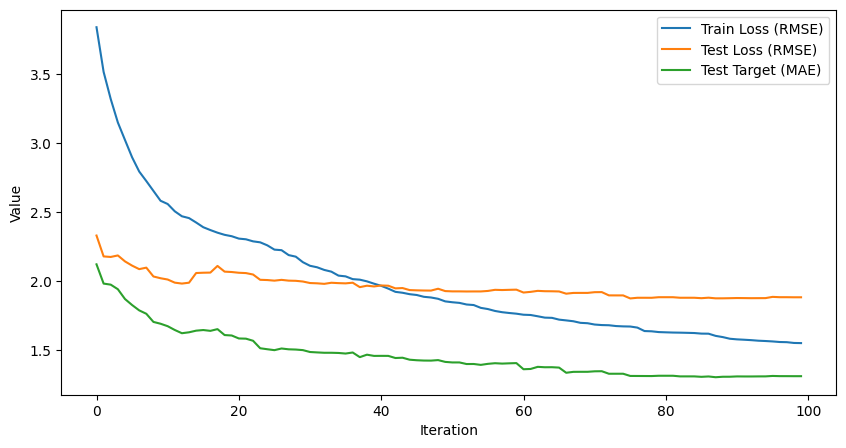

In [74]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_metric, label='Train Loss (RMSE)')
plt.plot(test_loss_metric, label='Test Loss (RMSE)')
plt.plot(test_target_metric, label='Test Target (MAE)')
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()

In [58]:
class CatBoost:
    def __init__(self, ):
        self.cbc = CatBoostRegressor()
        self.predictions = None

    def load(self, weights_path: str):
        self.cbc.load_model(weights_path, format='cbm')

    def predict(self, X: pd.DataFrame):

        pooled = Pool(data=X)

        self.predictions = self.cbc.predict(pooled).astype(np.int32)

        return self.predictions

In [59]:
model = CatBoost()
model.load(weights_path)
predictions = model.predict(X_test)

In [60]:
mean_absolute_error(y_test.values.astype(np.int32), predictions)

1.175